In [30]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")

library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

In [31]:
mlb2021=read.csv("./stats2021.csv")
mlb2021 = mlb2021[,-c(1,2,3,4)]

colnames(mlb2021)=c("strikeout","walk","batting","power","woba","velocity",
                 "angle","well-hit","hard","contact")

mlb_x = scale(mlb2021[,-5])
y= mlb2021[,5]

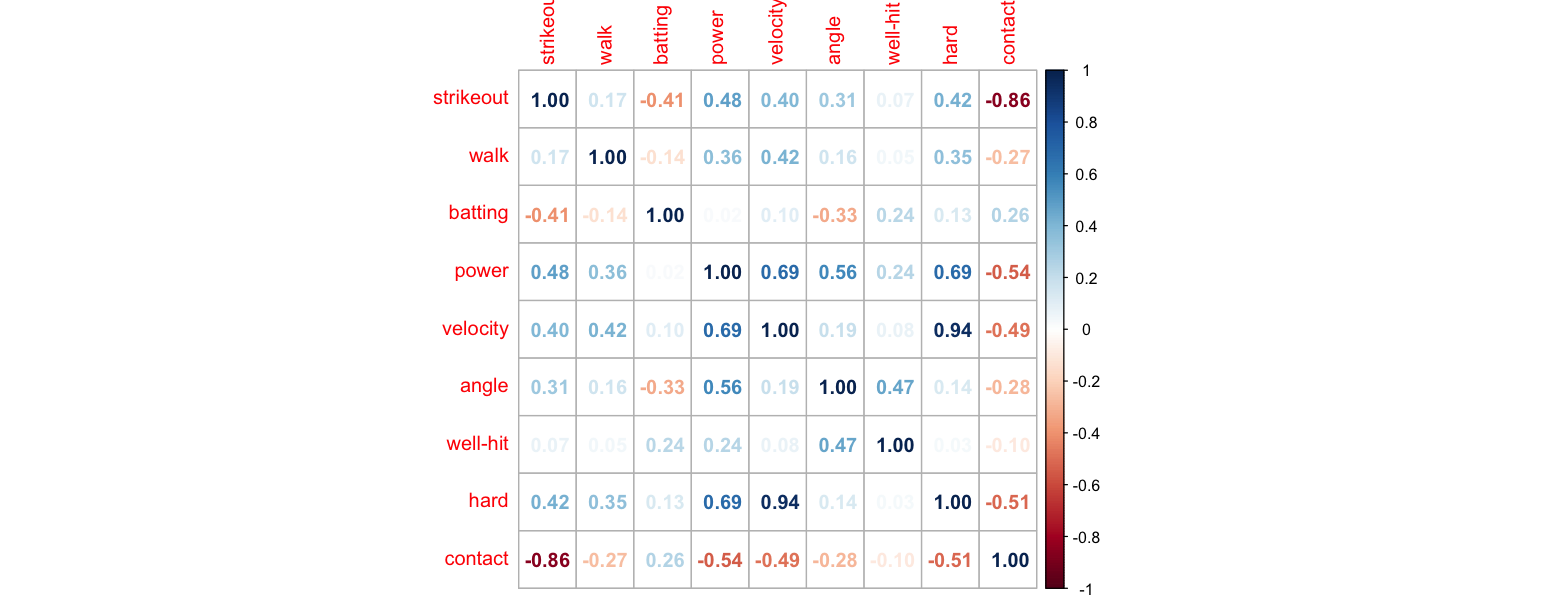

In [32]:
corr = cor(mlb_x)
corrplot(corr,method="number")

# Clustering

In [33]:
kk=5
t_a=Sys.time()
pam <- pam(mlb_x,kk)
t_b=Sys.time()
km <- KMeans_rcpp(mlb_x,kk)
t_c=Sys.time()
mocl <- MOCL_wcss(Xf=mlb_x,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=100),delta=0.01)
t_d=Sys.time()
skm <- Sparse_km(data=mlb_x,kk=kk,nperms_n=10)
t_e=Sys.time()
varsel <- VarSelCluster(mlb_x, kk, nbcores = 1, crit.varsel = 'BIC') 
t_f=Sys.time()

    

0123
0123


In [34]:
t_d-t_c
t_e-t_d
t_f-t_e

t_c-t_b
t_b-t_a

Time difference of 4.30736 secs

Time difference of 0.4684832 secs

Time difference of 1.340464 secs

Time difference of 0.00108099 secs

Time difference of 0.002449036 secs

In [35]:
clu_mocl=(kk+1)-mocl$cluster
clu_skm=skm$cluster_1sd
clu_vsl=fitted(varsel)
clu_km=km$cluster
clu_pam=pam$cluster

## Variable selection

In [36]:
sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)), 
                skm$sparse_1sd,slot(slot(varsel,'model'),'omega'))

rownames(sparse_mat)=c("MOCL","SKM","VSL")
sparse_mat

,strikeout,walk,batting,power,velocity,angle,well-hit,hard,contact
MOCL,1,1,0,1,1,1,1,1,1
SKM,1,0,0,1,1,0,0,1,1
VSL,1,1,0,1,1,0,0,1,1


## t-SNE

In [37]:
set.seed(243)
tsne<-Rtsne(mlb2021[,-5],dim=2,perplexity=30, verbose=TRUE, max_iter = 500)

Performing PCA
Read the 132 x 9 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.00 seconds (sparsity = 0.821281)!
Learning embedding...
Iteration 50: error is 50.075463 (50 iterations in 0.01 seconds)
Iteration 100: error is 51.493878 (50 iterations in 0.01 seconds)
Iteration 150: error is 52.334448 (50 iterations in 0.01 seconds)
Iteration 200: error is 54.661886 (50 iterations in 0.01 seconds)
Iteration 250: error is 51.110302 (50 iterations in 0.01 seconds)
Iteration 300: error is 1.211924 (50 iterations in 0.01 seconds)
Iteration 350: error is 0.577932 (50 iterations in 0.01 seconds)
Iteration 400: error is 0.383346 (50 iterations in 0.01 seconds)
Iteration 450: error is 0.380553 (50 iterations in 0.00 seconds)
Iteration 500: error is 0.380810 (50 iterations in 0.00 seconds)
Fitting performed in 0.08 seconds.


In [38]:
lab_mocl=as.factor(clu_mocl)
lab_skm=as.factor(clu_skm)
lab_vsl=as.factor(clu_vsl)
lab_km=as.factor(clu_km)
lab_pam=as.factor(clu_pam)

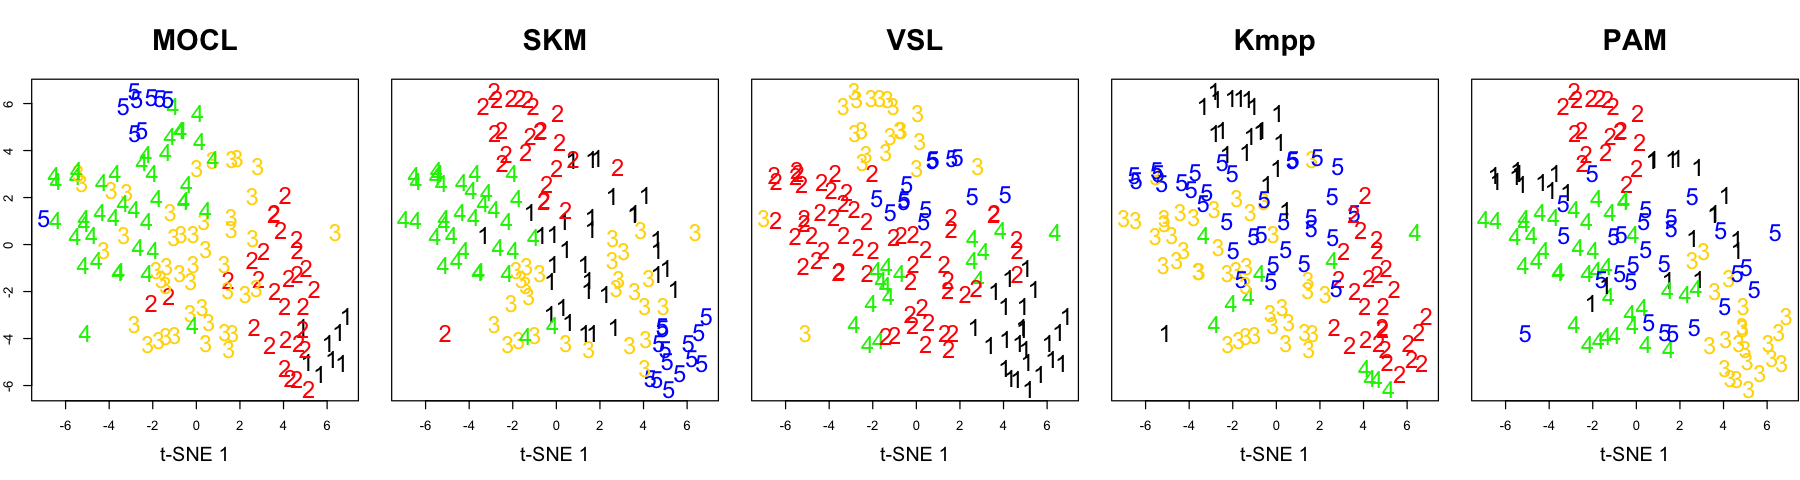

In [39]:
options(repr.plot.width = 15, repr.plot.height = 4)
par(mfrow=c(1,5))
par(mar=c(5,2,5,0.1))
#par(mar=c(5,3,5,3))

colors=c("Black","Red","Gold","Green 2","Blue")


pchs=c(0,2,3,4,5,1)
names(colors) = c(1:kk)
tsne_y=tsne$Y
################################
plot(tsne_y,t='n',col=lab_mocl,pch=19,main="MOCL",cex.main=2.2,
     xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_mocl, col=colors[lab_mocl],cex=1.8)


plot(tsne_y,t='n',col=lab_skm,pch=19,main="SKM",cex.main=2.2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_skm, col=colors[lab_skm],cex=1.8)
plot(tsne_y,t='n',col=lab_vsl,pch=19,main="VSL",cex.main=2.2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_vsl, col=colors[lab_vsl],cex=1.8)
plot(tsne_y,t='n',col=lab_km,pch=19,main="Kmpp",cex.main=2.2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_km, col=colors[lab_km],cex=1.8)
plot(tsne_y,t='n',col=lab_pam,pch=19,main="PAM",cex.main=2.2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_pam, col=colors[lab_pam],cex=1.8)

In [40]:
rand.index(clu_mocl,clu_skm)
rand.index(clu_mocl,clu_vsl)

[1] 0.7521397

[1] 0.6940782

## Rand index

In [41]:
rand.index(clu_mocl,clu_km)
rand.index(clu_mocl,clu_pam)
rand.index(clu_mocl,clu_skm)
rand.index(clu_mocl,clu_vsl)

[1] 0.7273884

[1] 0.7066852

[1] 0.7521397

[1] 0.6940782

## Estimated functions

In [42]:
dd=nor_minmax(mlb_x)
col_lst=c("Magenta","Blue","Gold","red","grey","Dark Magenta","Cyan","Dark Orange","Lime Green")

#Navy Blue

In [43]:
dd_mo=dd[,sparse_mat[1,]>0]
col_mo=col_lst[sparse_mat[1,]>0]
fx_mo=-mocl$fx[,sparse_mat[1,]>0]


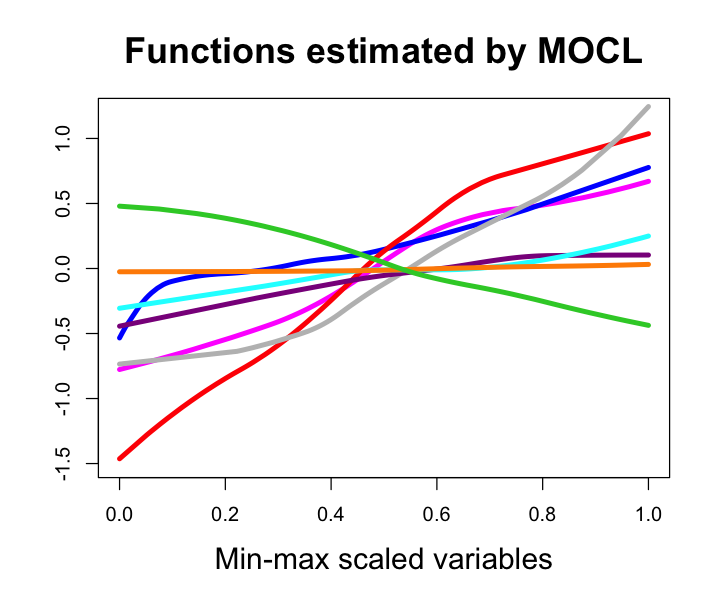

In [44]:
options(repr.plot.width = 6, repr.plot.height = 5)
#par(mfrow=c(1,2))
for(i in 1:ncol(dd_mo)){
    o_i=order(dd_mo[,i])
    if(i==1){
        plot(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],type="l",
             lwd=4,ylim=c(-1.5,1.2),xlim=c(0,1),main="Functions estimated by MOCL",
            xlab="Min-max scaled variables",ylab="",cex.main=1.8,cex.lab=1.5)
    }else{lines(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],lwd=4)}
}


# Correlation

In [45]:
cor(c(y),clu_mocl,method="spearman")

[1] 0.5414579

# Regression (MSLasso)

In [64]:
Z<-monotone.splines(nor_minmax(mlb_x), 6) 
y<-scale(y)

mslasso=Ad_MSLasso(Xf=mlb_x,Zf=Z,Yf=y,num.knotsf=6,max.lambda=1,
                   min.lambda=0.001,len.lambda=20,r_a=0.01)

y_hat=Z%*%mslasso$coef+mslasso$b0

dd_x=mlb_x
num.knotsf=6
groups <- as.vector(t(matrix(rep((1):(ncol(dd_x)),(num.knotsf+2)),ncol(dd_x),(num.knotsf+2))))

In [65]:
ms_coef=mslasso$coef
function_mat=matrix(0,nrow(dd_x),ncol(dd_x))

for(j in 1:ncol(dd_x)){
  coef_j=ms_coef[groups==j,]
  z_j=Z[,groups==j]
  function_mat[,j]=z_j%*%coef_j
}

In [66]:
dd_ms=nor_minmax(mlb_x)[,apply(function_mat,2,mean)^2>0]
fx_ms=function_mat[,apply(function_mat,2,mean)^2>0]
col_ms=col_lst[apply(function_mat,2,mean)^2>0]

In [67]:
head(dd_ms,3)

walk,batting,power
0.1978022,0.4461538,0.2454212
0.2582418,0.5153846,0.6227106
0.2527473,0.4692308,0.3003663


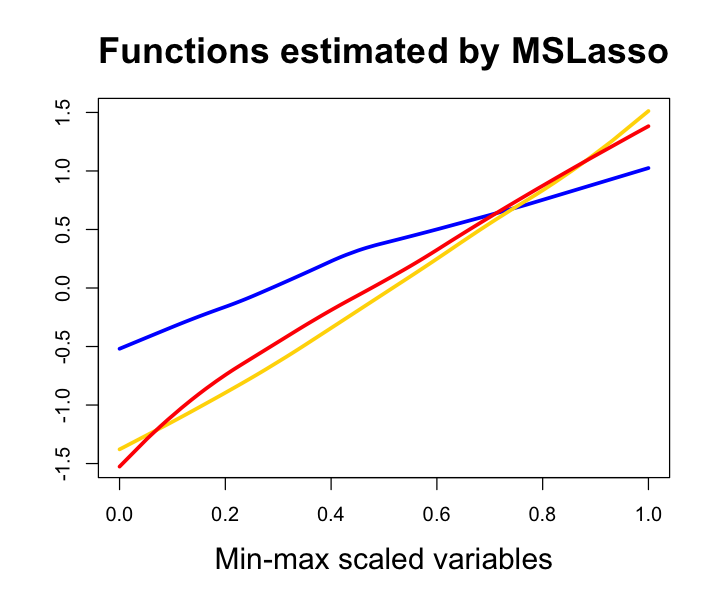

In [68]:
options(repr.plot.width = 6, repr.plot.height = 5)
plot(dd_ms[order(dd_ms[,1]),1],fx_ms[order(dd_ms[,1]),1],
     type="l",lwd=3,col=col_ms[1],main="Functions estimated by MSLasso",
    xlab="Min-max scaled variables",ylab="",cex.main=1.8,cex.lab=1.5,ylim=c(-1.5,1.5))

lines(dd_ms[order(dd_ms[,2]),2],fx_ms[order(dd_ms[,2]),2],
     type="l",lwd=3,col=col_ms[2])

lines(dd_ms[order(dd_ms[,3]),3],fx_ms[order(dd_ms[,3]),3],
     type="l",lwd=3,col=col_ms[3])


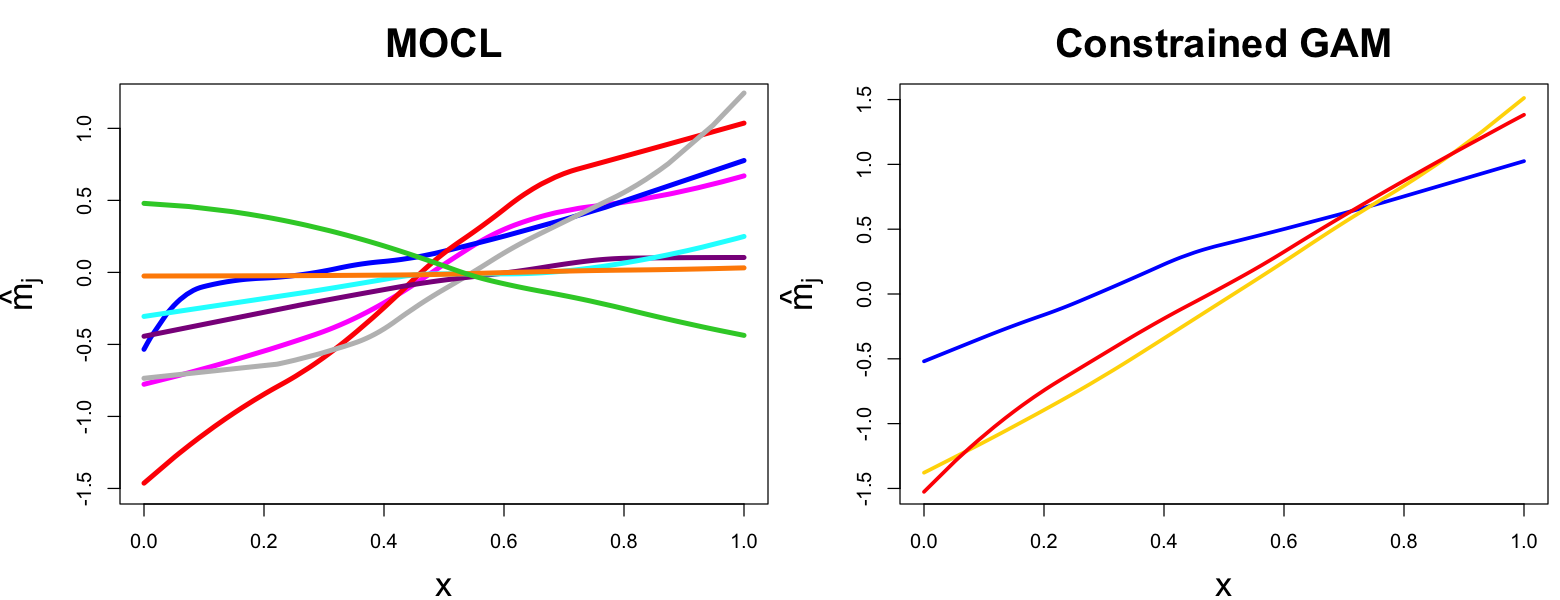

In [69]:
options(repr.plot.width = 13, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,3.5,0.5))

for(i in 1:ncol(dd_mo)){
    o_i=order(dd_mo[,i])
    if(i==1){
        plot(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],type="l",
             lwd=4,ylim=c(-1.5,1.2),xlim=c(0,1),main="MOCL",
            xlab=TeX("$x$"),ylab=TeX("$\\hat{m}_j$"),cex.main=2,cex.lab=1.7)
    }else{lines(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],lwd=4)}
}




plot(dd_ms[order(dd_ms[,1]),1],fx_ms[order(dd_ms[,1]),1],
     type="l",lwd=3,col=col_ms[1],main="Constrained GAM",
    xlab=TeX("$x$"),ylab=TeX("$\\hat{m}_j$"),cex.main=2,cex.lab=1.7,ylim=c(-1.5,1.5))

lines(dd_ms[order(dd_ms[,2]),2],fx_ms[order(dd_ms[,2]),2],
     type="l",lwd=3,col=col_ms[2])

lines(dd_ms[order(dd_ms[,3]),3],fx_ms[order(dd_ms[,3]),3],
     type="l",lwd=3,col=col_ms[3])

In [71]:
cluster_mat=cbind(clu_mocl,clu_skm,clu_vsl,clu_km,clu_pam)
colnames(cluster_mat)=c("MOCL","SKM","VSL","Kmpp","PAM")

baseball_lst=list()


baseball_lst[["X"]]=mlb2021[,-5]
baseball_lst[["y"]]=mlb2021$woba
baseball_lst[["cluster_mat"]]=cluster_mat
baseball_lst[["var_sel"]]=sparse_mat
baseball_lst[["mocl"]]=mocl
baseball_lst[["fx_mslasso"]]=function_mat
###############################
# Save
saveRDS(baseball_lst,file="Baseball_K5.RData")